In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

df = pd.read_excel("dataset.xlsx")
df.drop(columns=["Seli", "Tarih"], inplace=True, errors='ignore')

# mccinfo'dan "-" öncesindeki dört rakamı çıkarıyoruz
def extract_mcc(value):
    if pd.isnull(value):
        return np.nan
    match = re.match(r"(\d{4})-", value)
    if match:
        return match.group(1)
    else:
        return np.nan

df['mccinfo'] = df['mccinfo'].apply(extract_mcc)

# mccinfo değeri bulunamayan satırları siliyoruz
num_missing_mcc = df['mccinfo'].isnull().sum()
print(f"mccinfo değeri bulunamadığı için silinecek satır sayısı: {num_missing_mcc}")
df = df.dropna(subset=['mccinfo'])

# Sayısal sütunlarda formatlama işlemleri
numeric_columns = [
    "bıst100_Kapanış", "bıst100_Açılış", "bıst100_Yüksek", "bıst100_Düşük",
    "Euro_Kapanış", "Euro_Açılış", "Euro_Yüksek", "Euro_Düşük",
    "USD_Kapanış", "USD_Açılış", "USD_Yüksek", "USD_Düşük",
]

def fix_numeric_value(s):
    s = s.replace(',', '.')
    if s.count('.') > 1:
        second_dot = s.find('.', s.find('.') + 1)
        s = s[:second_dot]
    return s

for col in numeric_columns:
    df[col] = df[col].astype(str).apply(fix_numeric_value)
    df[col] = df[col].astype(float)

# Kategorik sütunlar için one-hot encoding
categorical_columns = ["Şehir", "İlçe", "mccinfo"]
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

print("Ön işleme tamamlandı.")

mccinfo değeri bulunamadığı için silinecek satır sayısı: 15
Ön işleme tamamlandı.


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Hedef ve özelliklerin ayrılması
target = "Tek Çekim Komisyon Oranı (Güncel)"
X = df.drop(columns=[target])
y = df[target]

# XGBoost regressor'ı varsayılan parametrelerle başlatıyoruz.
# random_state ile tekrar üretilebilir sonuçlar elde ediyoruz.
model = XGBRegressor(random_state=42)

# 10 katlı cross validation ile tahmin yapıyoruz.
y_pred = cross_val_predict(model, X, y, cv=10)

# Değerlendirme metriklerini hesaplıyoruz.
mae = mean_absolute_error(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"r2: {r2:.4f}")




MAE: 0.3252
MAPE: 0.0798
R2: 0.6371


In [8]:
tf = pd.DataFrame({'Gerçek': y, 'Tahmin': y_pred})

tf.head(10)

,Gerçek,Tahmin
0,3.49,3.956944
1,3.60,3.997786
2,3.90,4.111734
3,3.15,2.217002
4,2.56,2.500309
5,1.00,1.212646
6,2.87,2.591536
7,3.65,3.999040
8,3.35,2.695227
9,3.35,3.328838


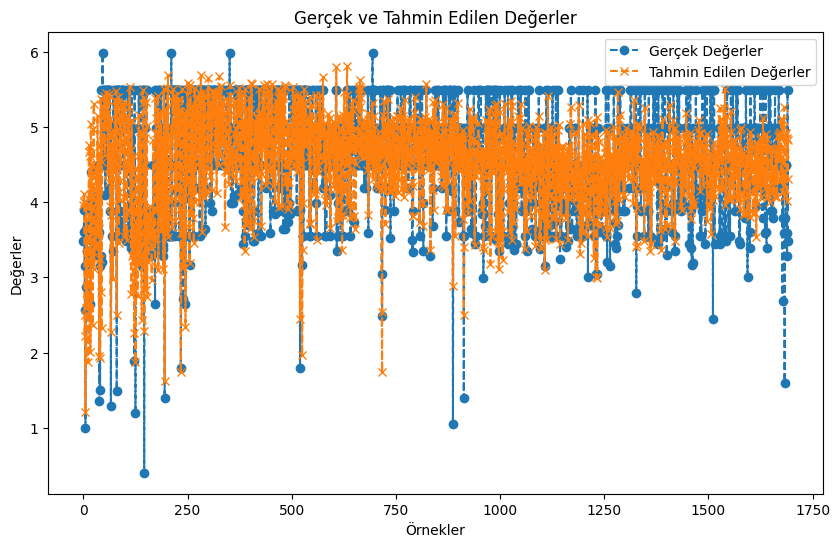

In [3]:
# -------------------- Grafik -------------------- #
# Örnek indekslerine göre gerçek ve tahmin edilen değerleri çiziyoruz.
plt.figure(figsize=(10, 6))
plt.plot(range(len(y)), y, label="Gerçek Değerler", marker="o", linestyle="--")
plt.plot(range(len(y_pred)), y_pred, label="Tahmin Edilen Değerler", marker="x", linestyle="--")
plt.xlabel("Örnekler")
plt.ylabel("Değerler")
plt.title("Gerçek ve Tahmin Edilen Değerler")
plt.legend()
plt.show()